#MOMENTUM TREND FOLLOWING (BASIC)

In [6]:
!pip install yfinance ta

import yfinance as yf
import pandas as pd
import ta

# Download AAPL daily OHLCV data
aapl = yf.download("AAPL", start="2018-01-01", end="2024-12-31")

# Compute returns
aapl['return_1d'] = aapl['Close'].pct_change(1)
aapl['return_5d'] = aapl['Close'].pct_change(5)

# Simple moving averages
aapl['sma_5'] = aapl['Close'].rolling(window=5).mean()
aapl['sma_20'] = aapl['Close'].rolling(window=20).mean()

# RSI (momentum indicator)
aapl['rsi_14'] = ta.momentum.RSIIndicator(close=aapl['Close'].squeeze(), window=14).rsi()

# Volatility
aapl['volatility_5d'] = aapl['Close'].rolling(window=5).std()

# Drop rows with NaNs
aapl.dropna(inplace=True)

aapl.tail()


/tmp/ipython-input-6-701975329.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  aapl = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,return_1d,return_5d,sma_5,sma_20,rsi_14,volatility_5d
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2024-12-23,254.655716,255.034791,252.840088,254.156919,40858800,0.003065,0.016850,251.609055,244.437349,73.085652,3.128407
2024-12-24,257.578674,257.588630,254.675658,254.875189,23234700,0.011478,0.018621,252.550790,245.700803,75.750286,4.146076
2024-12-26,258.396667,259.474086,257.010028,257.568678,27237100,0.003176,0.044225,254.739508,246.895920,76.452878,3.639882
2024-12-27,254.974930,258.077462,252.451019,257.209530,42355300,-0.013242,0.023219,255.896716,247.926434,67.626271,1.971381
2024-12-30,251.593079,252.889953,250.146571,251.623005,35557500,-0.013263,-0.008998,255.439813,248.668145,60.225562,2.690075


In [7]:
#Step 2: labeling the data (Supervised Learning)
# Define the target: Will the return over next 5 days be positive?
aapl['target'] = (aapl['Close'].shift(-5) > aapl['Close']).astype(int)

# Drop last 5 rows (since target is NaN due to shift)
aapl.dropna(inplace=True)

# Final dataset shape
print(aapl.shape)
aapl[['Close', 'target']]


(1741, 12)


Price,Close,target
Ticker,AAPL,
Date,,
2018-01-30,39.185349,0
2018-01-31,39.293308,0
2018-02-01,39.375431,0
2018-02-02,37.666927,0
2018-02-05,36.725838,1
...,...,...
2024-12-23,254.655716,0
2024-12-24,257.578674,0


              precision    recall  f1-score   support

           0       0.45      0.86      0.59       152
           1       0.63      0.19      0.29       197

    accuracy                           0.48       349
   macro avg       0.54      0.52      0.44       349
weighted avg       0.55      0.48      0.42       349



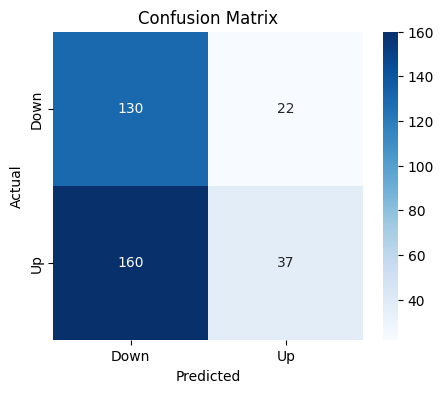

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Feature columns
features = ['return_1d', 'return_5d', 'sma_5', 'sma_20', 'rsi_14', 'volatility_5d']
X = aapl[features]
y = aapl['target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

/tmp/ipython-input-9-2267723870.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')


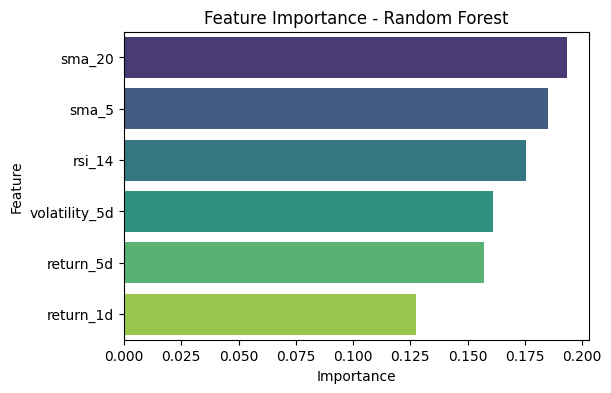

In [9]:
# Feature importance
importances = model.feature_importances_
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.show()

In [10]:
# Get probability of class '1' (price up)
proba = model.predict_proba(X_test)[:, 1]

# Only take trades where prob > 0.6
threshold = 0.6
test_signals = proba > threshold

# Simulate 5-day forward return
future_returns = aapl.iloc[y_test.index]['Close'].shift(-5) / aapl.iloc[y_test.index]['Close'] - 1

# Strategy returns where signal is active
strategy_returns = future_returns[test_signals]

# Benchmark returns (buy and hold)
benchmark_returns = future_returns

# Print average returns
print("Strategy Avg Return (5d hold):", strategy_returns.mean())
print("Benchmark Avg Return:", benchmark_returns.mean())
print("Number of trades taken:", test_signals.sum())

IndexError: positional indexers are out-of-bounds

In [11]:
# Get probability of class '1' (price up)
proba = model.predict_proba(X_test)[:, 1]

# Only take trades where prob > 0.6
threshold = 0.6
test_signals = proba > threshold

# Simulate 5-day forward return using .loc (not .iloc)
future_returns = aapl.loc[y_test.index]['Close'].shift(-5) / aapl.loc[y_test.index]['Close'] - 1

# Strategy returns where signal is active
strategy_returns = future_returns[test_signals]

# Benchmark returns (buy and hold)
benchmark_returns = future_returns

# Print average returns
print("Strategy Avg Return (5d hold):", strategy_returns.mean())
print("Benchmark Avg Return:", benchmark_returns.mean())
print("Number of trades taken:", test_signals.sum())

Strategy Avg Return (5d hold): Ticker
AAPL    0.005993
dtype: float64
Benchmark Avg Return: Ticker
AAPL    0.005966
dtype: float64
Number of trades taken: 43
